In [1]:
!pip install -qqU py-boost iterative-stratification

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
virtualenv 20.16.5 requires importlib-metadata>=4.8.3; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
keyring 23.6.0 requires importlib-metadata>=3.6; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
gym 0.26.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you h

In [2]:
from py_boost import GradientBoosting, SketchBoost

from py_boost.multioutput.sketching import *
from py_boost.multioutput.target_splitter import *

from py_boost.gpu.losses import Loss, Metric
import cupy as cp

In [3]:
import warnings
warnings.filterwarnings("ignore")
import time
from functools import partial
from tqdm import trange
import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno as msno

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import optuna
from optuna.samplers import TPESampler

In [4]:
train_drug = pd.read_csv("/kaggle/input/lish-moa/train_drug.csv")
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")

targets = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")

In [5]:
def multi_logloss(y_true, y_pred, sample_weights=None, activation=True):
    """
    y_true: array of shape [N, M], where sample X_ij - 0 or 1 (dtype: np.int32),
    y_pred: array of shape [N, M], where sample X_ij - [0, 1] - estimated probability of being positive (dtype: np.float32)
    sample_weigts: array of shape [N, M], where every vector [N, 1] consists of sample weights (dtype: np.float32)
    N - number of samples 
    M - number of classes
    returns:
        Scalar float value of computed loss
    """
    if sample_weights is None:
        sample_weights = np.ones_like(y_true)  # [N, M]

    norm = np.sum(sample_weights, axis=0)
    if activation:
        y_pred = 1 / (1 + np.exp(-y_pred))  # sigmoid activation
    y_pred = np.clip(y_pred, 0.001, 0.999)
    loss = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)  # [N, M]
    loss = loss * sample_weights
    loss = np.sum(loss, axis=0)  # sum over all samples per class  [1, M]
    loss = loss / norm  # normalize by weights sum, [1, M]
    return - loss.mean()  # .sum() sum[1, M] / M


class CustomMetric(Metric):
    
    def compare(self, v0 ,v1):
        
        return v0 < v1
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        final_metric = multi_logloss(y_true, y_pred, sample_weights=sample_weight, activation=False)
        
        return final_metric


class CustomLoss(Loss):
    smooth = 0.0  # 0.001
    clip_value = 1e-7
    
    def preprocess_input(self, y_true):
        y_true = y_true * (1 - self.smooth) + 0.5 * self.smooth
        
        return y_true
    
    def postprocess_output(self, y_pred):
        pred = 1 / (1 + cp.exp(-y_pred))  # sigmoid activation
        pred = cp.clip(pred, self.clip_value, 1 - self.clip_value)
        
        return pred
    
    def get_grad_hess(self, y_true, y_pred):
        pred = 1 / (1 + cp.exp(-y_pred))  # sigmoid activation
        pred = cp.clip(pred, 0.001, 0.999)  # clip extreme cases
        
        # first order derivative
        grad = pred - y_true  # same as for mse loss
        # second order derivative
        hess = pred * (1 - pred)
        
        return grad, hess

    def base_score(self, y_true):
        means = cp.clip(y_true.mean(axis=0), self.clip_value, 1 - self.clip_value)
        mean_log_odds = cp.log(means / (1 - means))  # logits to apply activation after
        
        return mean_log_odds
    
    def get_metric_from_string(self, name=None):
        if name is None:
            return CustomMetric()
        return metric_alias[name]


def print_scores(folds_scores, train_scores):
    print(f"Train score by each fold: {train_scores}")
    print(f"Valid score by each fold: {folds_scores}")
    print(f"Train mean score by each fold:{np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")
    print(f"Valid mean score by each fold:{np.mean(folds_scores):.5f} +/- {np.std(folds_scores):.5f}")
    print("*" * 50)

In [6]:
(np.unique(train_drug.sig_id) != np.unique(train_features.sig_id)).sum()

0

In [7]:
train_features.isna().sum().sum(), targets.isna().sum().sum()

(0, 0)

<AxesSubplot:>

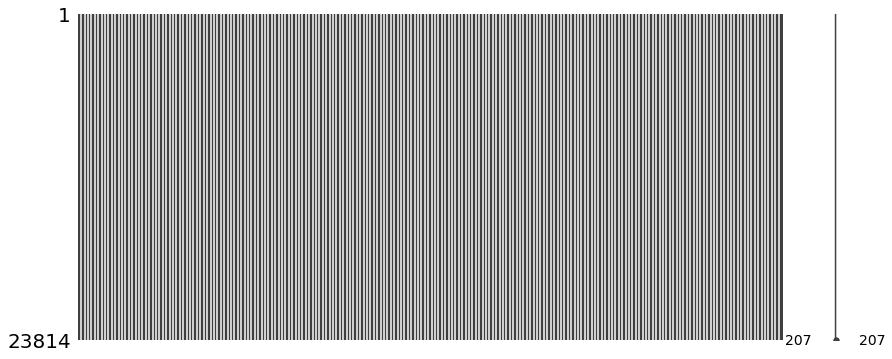

In [8]:
msno.matrix(targets.replace({0.0, np.nan}), figsize=(14,6))

In [9]:
num_empty = 0
for column in targets.columns:
    if not np.any(targets[column].values):
        num_empty += 1
num_empty

0

In [10]:
np.sum(targets.sum(axis=1) == 0)  # number of no-response

9367

In [11]:
np.sum(targets.sum(axis=1) > 1)  # number of multilabels

1915

In [12]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [13]:
genes = [column for column in train_features.columns if column.startswith("g-")]
cells = [column for column in train_features.columns if column.startswith("c-")]

In [13]:
train_features.describe(exclude="number")

,sig_id,cp_type,cp_dose
count,23814,23814,23814
unique,23814,2,2
top,id_000644bb2,trt_cp,D1
freq,1,21948,12147


In [14]:
train_drug.drug_id.nunique()

3289

In [7]:
train_features.cp_type = train_features.cp_type.map({'trt_cp': 0, 'ctl_vehicle': 1})
train_features.cp_dose = train_features.cp_dose.map({"D1": 0, "D2": 1})

In [7]:
# train_drug = train_drug.merge(train_features, on="sig_id", how="left")

In [16]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,0,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,0,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,0,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,0,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,0,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [17]:
targets[(targets.drop("sig_id", axis=1) < 1) & (targets.drop("sig_id", axis=1) > 0)].isna().sum()

sig_id                                   23814
5-alpha_reductase_inhibitor              23814
11-beta-hsd1_inhibitor                   23814
acat_inhibitor                           23814
acetylcholine_receptor_agonist           23814
                                         ...  
ubiquitin_specific_protease_inhibitor    23814
vegfr_inhibitor                          23814
vitamin_b                                23814
vitamin_d_receptor_agonist               23814
wnt_inhibitor                            23814
Length: 207, dtype: int64

In [8]:
targets.set_index("sig_id", inplace=True)
train_features.set_index("sig_id", inplace=True)

In [19]:
# optionally
# remove all zero rows, so that we have only scored labels
# expand multilabel rows, so that every row contains only one label, thus crossentropy

rows, indexes = [], []
for i, row in targets.iterrows():
    if np.sum(row) > 1:
        idxs = np.nonzero(row.values)
        for j in range(len(idxs)):
            new_row = np.zeros(len(row))
            new_row[j] = 1
            rows.append(new_row)
            indexes.append(row.name)
    elif np.sum(row) == 1:
        rows.append(row.values)
        indexes.append(row.name)

In [20]:
new_targets = pd.DataFrame(np.array(rows), columns=targets.columns.tolist(), index=indexes).astype(np.int32)
new_train = train_features[train_features.index.isin(new_targets.index)]

In [21]:
new_targets_flat = new_targets.idxmax(axis=1).map({v: i for i, v in enumerate(targets.columns)}).astype(np.int32)

In [9]:
k = int(np.sqrt(targets.shape[1]))

# sketch = RandomProjectionSketch(k)  # second order derivative: use_hess=False
sketch = RandomSamplingSketch(k)  # use_hess=True
# sketch = TopOutputsSketch(k)
# sketch = SVDSketch(n_components=k)

params = {"ntrees": 6000,  # number of trees (base estimators)
          "lr": 0.01, # every tree multiplier
          "verbose": 600, # print loss value after every 500 trees are constructed
          "es": 100,  # stop training, when loss didn't improve during 100 trees
          "lambda_l2": 10, # l2 regularization: sum(grads)*idx / (sum(hess) + lambda)
          "gd_steps": 1, # number of newton iterations
          "subsample": 0.6,  # sample 0.6 part of training data for each tree
          "colsample": 0.8,  # sample 0.8 number of features per tree / tree level
          "min_data_in_leaf": 20,  # min data samples in leaf (prevents overfitting)
          "use_hess": True,  # use second derivative in scoring function when constructing tree, False - to speedup
          "max_bin": 32,  # group feature values into bins to speedup optimal tree structure searching 
          "max_depth": 3,  # maximum depth of each tree to prevent overfitting
          "multioutput_sketch": sketch  # type of output dimension reduction: sort, prob sample or projection
         }  

In [18]:
def sketch_cross_validation(params, X, y, cv, categorical=None, verbose=True, transform=False):
    estimators, encoders = [], {}
    folds_scores, train_scores = [], []
    oof_preds = np.zeros((X.shape[0], y.shape[1]))
    
    if categorical is not None:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature])
            encoders[feature] = encoder
            
    if transform:  # use all data statistics [which is not quite honest: data leakage]
        # such tranforms may be more suitable for models that use optimization approaches (e.g. neural networks)
        # DCNN architecture would well fit this task
        X = X.copy(deep=True)
        pipeline = make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=42),
                                 PCA(n_components=600, random_state=42))
        xgenes = pd.DataFrame(pipeline.fit_transform(X[genes]), 
                              columns=[f"G_{i}" for i in range(1, pipeline[-1].n_components_+1)],
                              index=X.index)

        pipeline = make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=42),
                                 PCA(n_components=50, random_state=42))
        xcells = pd.DataFrame(pipeline.fit_transform(X[cells]), 
                              columns=[f"G_{i}" for i in range(1, pipeline[-1].n_components_+1)],
                              index=X.index)

        X.drop(genes+cells, axis=1, inplace=True)
        X = pd.concat([X, xgenes, xcells], axis=1)

    if verbose:
        print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train, y_valid = y.iloc[train_idx, :], y.iloc[valid_idx, :]
        
        # here define honest (non-shifted) encoder
        # encoder = ce.cat_boost.CatBoostEncoder(a=3.0, random_state=42)  # CatBoost encoding - drug_id
        # x_train[feature] = encoder.fit_transform(x_train[feature], y_train.idxmax(1).astype(np.int32))
        # x_valid[feature] = encoder.transform(x_valid[feature])
        # encoders.update

        # predict each prob with sigmoid: [N, M], otherwise "crossentropy" [N, ] having target [1,N] - each row labeled [0,num_classes)
        # model = GradientBoosting("multilabel", **params)  # oof-score+projection: 0.01586 
        
        model = GradientBoosting(CustomLoss(), CustomMetric(), **params)
        model.fit(x_train.values.astype(np.float32), y_train.values.astype(np.int32), 
                  eval_sets=[{'X': x_valid.values.astype(np.float32), 'y': y_valid.values.astype(np.int32)}])
        
        train_pred = model.predict(x_train.values.astype(np.float32))
        train_score = multi_logloss(y_train.values, train_pred, activation=False)
        
        train_auc_score = []
        for i in range(y_train.shape[1]):  # cv takes some all-zero classes
            if np.any(y_train.values[:, i]):
                auc_score = roc_auc_score(y_true=y_train.values[:, i], y_score=train_pred[:, i])
            else:
                auc_score = 0  # or random = 0.5
            train_auc_score.append(auc_score)
        train_auc_score = np.mean(train_auc_score)

        oof_preds[valid_idx] = model.predict(x_valid.values.astype(np.float32))
        score = multi_logloss(y_valid.values, oof_preds[valid_idx], activation=False)
        
        valid_auc_score = []
        for i in range(y_valid.shape[1]):
            if np.any(y_valid.values[:, i]):
                auc_score = roc_auc_score(y_true=y_valid.values[:, i], y_score=oof_preds[valid_idx, i])
            else:
                auc_score = 0
            valid_auc_score.append(auc_score)
        valid_auc_score = np.mean(valid_auc_score)
        
        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))
        
        if verbose:
            print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
            print(f"\tTrain roc_auc: {train_auc_score:.5f}, valid roc_auc_score: {valid_auc_score:.5f}")
        estimators.append(model)

    if verbose:
        print_scores(folds_scores, train_scores)
        print(f"OOF-score: {multi_logloss(y.values, oof_preds, activation=False):.5f}")

    return estimators, encoders, oof_preds

In [36]:
cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # [N,M] - thus labels are not mutualy exclusive

estimators, encoders, oof_preds = sketch_cross_validation(params, train_features, targets, cv, categorical=None)

Fri Dec 30 13:45:12 2022, Cross-Validation, 23814 rows, 875 cols
[13:45:16] Stdout logging level is INFO.
[13:45:16] GDBT train starts. Max iter 6000, early stopping rounds 100
[13:45:16] Iter 0; Sample 0, score = 0.02078499928852655; 
[13:45:39] Iter 600; Sample 0, score = 0.017289330252865654; 
[13:46:02] Iter 1200; Sample 0, score = 0.016782122382183476; 
[13:46:24] Iter 1800; Sample 0, score = 0.016497246722867044; 
[13:46:47] Iter 2400; Sample 0, score = 0.01630995624930399; 
[13:47:09] Iter 3000; Sample 0, score = 0.016174393673905305; 
[13:47:32] Iter 3600; Sample 0, score = 0.01607290882531078; 
[13:47:54] Iter 4200; Sample 0, score = 0.01599172496911858; 
[13:48:17] Iter 4800; Sample 0, score = 0.015926424347597605; 
[13:48:40] Iter 5400; Sample 0, score = 0.015871727017801658; 
[13:49:02] Iter 5999; Sample 0, score = 0.01582718617569896; 
Fold 1, Train score = 0.01228, Valid score = 0.01583
	Train roc_auc: 0.97338, valid roc_auc_score: 0.72167
[13:49:20] Stdout logging level 

In [19]:
cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimators, encoders, oof_preds = sketch_cross_validation(params, train_features, targets, cv, categorical=None, transform=True)

Fri Dec 30 14:57:16 2022, Cross-Validation, 23814 rows, 653 cols
[14:57:30] Stdout logging level is INFO.
[14:57:30] GDBT train starts. Max iter 6000, early stopping rounds 100
[14:57:47] Iter 0; Sample 0, score = 0.020788348468649374; 
[14:58:06] Iter 600; Sample 0, score = 0.017952960191992186; 
[14:58:24] Iter 1200; Sample 0, score = 0.01741784492316739; 
[14:58:43] Iter 1800; Sample 0, score = 0.017144145117571223; 
[14:59:01] Iter 2400; Sample 0, score = 0.01697146836599343; 
[14:59:20] Iter 3000; Sample 0, score = 0.01684484400887352; 
[14:59:38] Iter 3600; Sample 0, score = 0.01673899862728735; 
[14:59:57] Iter 4200; Sample 0, score = 0.016652159715913703; 
[15:00:15] Iter 4800; Sample 0, score = 0.016580531441676653; 
[15:00:34] Iter 5400; Sample 0, score = 0.016521525770064414; 
[15:00:52] Iter 5999; Sample 0, score = 0.01646595360942152; 
Fold 1, Train score = 0.01247, Valid score = 0.01647
	Train roc_auc: 0.98655, valid roc_auc_score: 0.70969
[15:01:11] Stdout logging level 

In [ ]:
# TODO
# feature engineering

# mean, kurtosis, skew, square, interactions: separatelly for G nad C: in progress
# PCA: Genes_comp = 600, cells_comp = 50 + QuantileTransform (normal distribution) / StandardScaler

In [11]:
# CI on oof-score

def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> list:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> tuple:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [73]:
# train full model

params = {"ntrees": 6000,
          "lr": 0.01,
          "verbose": -1,
          "lambda_l2": 10,
          "gd_steps": 1,
          "subsample": 0.6,
          "colsample": 0.8,
          "min_data_in_leaf": 20,
          "use_hess": False,
          "max_bin": 32,
          "max_depth": 3,
          "multioutput_sketch": sketch
         }  


model = GradientBoosting("multilabel", **params)  

# drug_id was encoded inplace in CV loop / not used as test_features has not such feature
model.fit(train_features.values.astype(np.float32), targets.values.astype(np.int32))

In [17]:
# make bootstrap samples to model metric distribution, select 95% confidence interval by percentile
# so, if the given model is stable it is expected due to Central Limit Theoreme that metrics are normally distributed
# and with confidence (probability) of p (here 95%) the truth metric value on inifity size sample would be in 
# inside this range, thus we are expecting to obtain metric in this range on unseen data with equal to train distribution

bootstrap_scores = create_bootstrap_metrics(targets.values, oof_preds, metric=partial(multi_logloss, activation=False))
calculate_confidence_interval(bootstrap_scores)

(0.015667531393919795, 0.01604594758308204)

In [59]:
# test submission
test_features = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
sample_sub = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

In [ ]:
train_drug[train_drug["sig_id"].isin(test_features.sig_id)]

In [75]:
test_features.cp_type = test_features.cp_type.map({'trt_cp': 0, 'ctl_vehicle': 1})
test_features.cp_dose = test_features.cp_dose.map({"D1": 0, "D2": 1})
test_features.set_index("sig_id", inplace=True)

# t = pd.read_csv("/kaggle/input/lish-moa/train_drug.csv")["drug_id"]
# encoders["drug_id"] = dict(zip(t.values.tolist(), train_drug["drug_id"].values.tolist()))
# no drug_id?
# test_features["drug_id"] = test_features["drug_id"].map(encoders["drug_id"])

In [76]:
sample_sub.iloc[:, 1:] = model.predict(test_features.values.astype(np.float32))
sample_sub.to_csv('submission.csv',index=False)

In [29]:
# feature selection: permutation importance

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: np.ndarray,
                                     y_valid: np.ndarray,
                                     maximize: bool = False,
                                     probas: bool = False,
                                     columns: list = None,
                                     ) -> pd.Series:

    def _predict(estimator, x_valid, probas=True):
        if hasattr(estimator, "predict_proba") and probas:
            y_pred = estimator.predict_proba(x_valid)[:, 1]
        else:
            y_pred = estimator.predict(x_valid)

        return y_pred

    y_pred = _predict(estimator, x_valid, probas)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for i in trange(x_valid.shape[1]):
        x_valid_ = copy.deepcopy(x_valid)
        dtype = x_valid_[:, i].dtype
        np.random.seed(42)
        x_valid_[:, i] = np.random.permutation(x_valid_[:, i])
        x_valid_[:, i] = x_valid_[:, i].astype(dtype)

        y_pred = _predict(estimator, x_valid_, probas)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[columns[i]] = base_score - feature_score
        else:
            delta[columns[i]] = feature_score - base_score

        scores[columns[i]] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [30]:
cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, valid_idx = next(iter(cv.split(train_features, targets)))

perm_model = GradientBoosting("multilabel", **params)  
perm_model.fit(train_features.iloc[train_idx, :].values.astype(np.float32), 
               targets.iloc[train_idx, :].values.astype(np.int32))

scores, deltas = calculate_permutation_importance(perm_model,
                                                  partial(multi_logloss, activation=False), 
                                                  train_features.iloc[valid_idx, :].values.astype(np.float32),
                                                  targets.iloc[valid_idx, :].values.astype(np.int32),
                                                  columns=train_features.columns.tolist())

100%|██████████| 875/875 [1:12:20<00:00,  4.96s/it]


In [35]:
deltas[deltas>0].to_dict()

{'c-65': 0.000830453615714332,
 'c-98': 0.00013651671816113792,
 'cp_type': 0.00012257825485802176,
 'g-178': 0.00011551029220621331,
 'g-175': 0.00011403923172112126,
 'g-100': 9.818649561012943e-05,
 'g-512': 8.776692989578491e-05,
 'c-78': 5.9864116332280365e-05,
 'g-392': 5.828528618574344e-05,
 'g-75': 5.706459995039395e-05,
 'g-157': 5.576714383242337e-05,
 'g-763': 3.7470654855462776e-05,
 'g-414': 3.702651305615909e-05,
 'g-300': 3.1518016634746876e-05,
 'g-91': 2.7966650252835012e-05,
 'g-231': 2.682532076599825e-05,
 'g-357': 2.5579478802811167e-05,
 'g-628': 2.544874871971553e-05,
 'g-202': 2.4426946446252235e-05,
 'g-20': 2.3882961607001735e-05,
 'g-47': 2.2292538744198703e-05,
 'g-158': 2.080915696544075e-05,
 'g-22': 1.8461243703402075e-05,
 'g-635': 1.7415416807196188e-05,
 'c-30': 1.7189612942999227e-05,
 'g-332': 1.713347705404114e-05,
 'g-387': 1.6420359507184068e-05,
 'g-493': 1.603599642736528e-05,
 'g-385': 1.5455562984014598e-05,
 'g-640': 1.5151858036830529e-05,


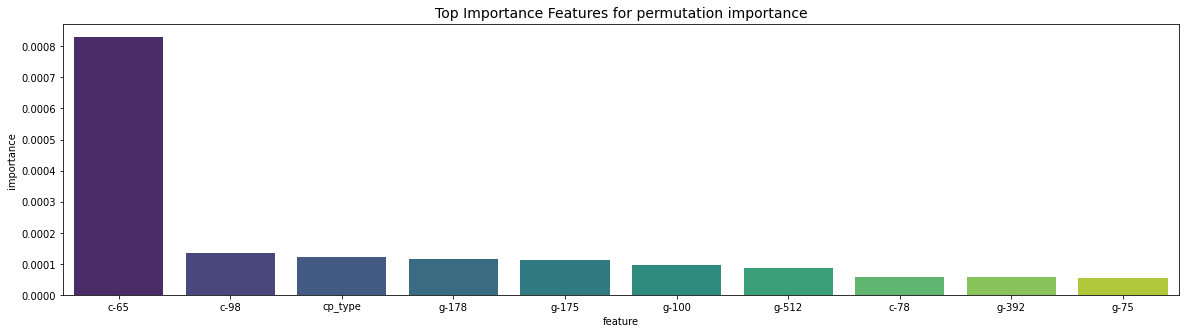

In [39]:
# visualize top10 importances
import seaborn as sns

importance = pd.DataFrame({
    "feature": deltas.index,
    "importance": deltas.values
})
importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top Importance Features for permutation importance", size=14)
plt.show()

<AxesSubplot:xlabel='c-65', ylabel='Count'>

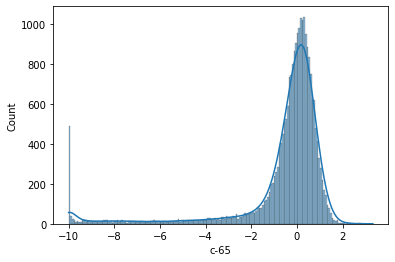

In [40]:
sns.histplot(x="c-65", data=train_features, kde=True)

In [41]:
train_features["c-65"].describe()

count    23814.000000
mean        -0.619682
std          2.225596
min        -10.000000
25%         -0.603200
50%          0.007650
75%          0.441250
max          3.328000
Name: c-65, dtype: float64

In [65]:
selected_train = train_features[deltas[deltas>0].index.tolist()].copy(deep=True)

In [62]:
# commented as important information lost
# for column in selected_train.drop(["cp_type", "cp_dose"], axis=1).columns:
#     p_1 = np.percentile(selected_train[column], 0.015)
#     p_2 = np.percentile(selected_train[column], 0.99)
#     selected_train[column] = np.clip(selected_train[column], a_min=p_1, a_max=p_2)

In [68]:
k = int(np.sqrt(targets.shape[1]))
# sketch = RandomProjectionSketch(k)  # use_hess=False - S(R=leaf) = sum(1..d) (sum(gi^2)/(sum(hi) + l2)), d=num_classes
# gi = d'L/(da=prev_tree_out), hi = d"L/da, where L = BCE/MSE/XE...
"""
use matrix P, sampled from N(0, 1/k), so that jacobian Gk[N,K] = Gd[N,D]@P[D,K]
Train mean score by each fold:0.01331 +/- 0.00002
Valid mean score by each fold:0.01584 +/- 0.00013
**************************************************
OOF-score: 0.01584
"""
# sketch = RandomSamplingSketch(k)  # use_hess=True (add second derivative part - diagonal hessian in tree-split computation)
# in leaf estimation hessian is always applied
"""
compute all class-gradients norms and total norms, sample every class with probability of:
pi = ||gi|| / sum(||gj||), i = 1..d, j = 1..d + normalize gi_ = gi / sqrt(k*pi)
Train mean score by each fold:0.01239 +/- 0.00002
Valid mean score by each fold:0.01581 +/- 0.00013
**************************************************
OOF-score: 0.01581
"""
sketch = TopOutputsSketch(k)  # use_hess=False
"""
select top-k classes that have highest gradient norms
Train mean score by each fold:0.01314 +/- 0.00003
Valid mean score by each fold:0.01631 +/- 0.00012
**************************************************
OOF-score: 0.01631
"""
    
params = {"ntrees": 5000,  # number of trees (base estimators)
          "lr": 0.01, # every tree multiplier
          "verbose": 500, # print loss value after every 500 trees are constructed
          "es": 100,  # stop training, when loss didn't improve during 100 trees
          "lambda_l2": 10, # l2 regularization: sum(grads)*idx / (sum(hess) + lambda)
          "gd_steps": 1, # number of newton iterations
          "subsample": 0.6,  # sample 0.6 part of training data for each tree
          "colsample": 0.8,  # sample 0.8 number of features per tree / tree level
          "min_data_in_leaf": 20,  # min data samples in leaf (prevents overfitting)
          "use_hess": False,  # use second derivative in scoring function when constructing tree, False - to speedup
          "max_bin": 32,  # group feature values into bins to speedup optimal tree structure searching 
          "max_depth": 3,  # maximum depth of each tree to prevent overfitting
          "multioutput_sketch": sketch  # type of output dimension reduction: sort, prob sample or projection
         }  

cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimators_, encoders_, oof_preds_ = sketch_cross_validation(params, selected_train, targets, cv, categorical=None)

Tue Dec 27 15:12:29 2022, Cross-Validation, 23814 rows, 764 cols
[15:12:32] Stdout logging level is INFO.
[15:12:32] GDBT train starts. Max iter 5000, early stopping rounds 100
[15:12:32] Iter 0; Sample 0, BCE = 0.020731030125675468; 
[15:12:43] Iter 500; Sample 0, BCE = 0.017624854328690407; 
[15:12:54] Iter 1000; Sample 0, BCE = 0.01716590388231179; 
[15:13:06] Iter 1500; Sample 0, BCE = 0.01692762672133184; 
[15:13:17] Iter 2000; Sample 0, BCE = 0.016757973384063606; 
[15:13:28] Iter 2500; Sample 0, BCE = 0.016635080705471685; 
[15:13:39] Iter 3000; Sample 0, BCE = 0.01653241651464982; 
[15:13:50] Iter 3500; Sample 0, BCE = 0.01644582212286762; 
[15:14:01] Iter 4000; Sample 0, BCE = 0.016362825397127703; 
[15:14:12] Iter 4500; Sample 0, BCE = 0.016294192955092435; 
[15:14:23] Iter 4999; Sample 0, BCE = 0.016236177297524673; 
Fold 1, Train score = 0.01314, Valid score = 0.01635
[15:14:37] Stdout logging level is INFO.
[15:14:37] GDBT train starts. Max iter 5000, early stopping rounds

In [ ]:
# hyper-parameters tuning: optuna

tune_params = {"ntrees": 5000,
               "verbose": -1,
               "es": 100, 
               "lambda_l2": 10, 
               "gd_steps": 1,
               "subsample": 0.6,
               "colsample": 0.8,
               "max_bin": 32,
               }
sketches = [
    RandomProjectionSketch(k),
    RandomSamplingSketch(k),
    TopOutputsSketch(k)
]

def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'lr': trial.suggest_float('lr', 0.003, 0.1),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'use_hess': trial.suggest_categorical('use_hess', [True, False]),
                    'multioutput_sketch': trial.suggest_categorical(multioutput_sketch, sketches),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf': 15, 200),
                    }
    
    param_trials.update(tune_params)

    fold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    _, _, oof_preds = sketch_cross_validation(param_trials, train_features, targets, fold, categorical=None)
    score = multi_logloss(targets, oof_preds, activation=False)
    
    return score

In [ ]:
# %%time
# optuna.logging.set_verbosity(optuna.logging.FATAL)
# study = optuna.create_study(sampler=TPESampler(seed=seed), direction="minimize")
# study.optimize(objective, n_trials=1500, timeout=10000)
# 
# print(f'Number of completed trials: {len(study.trials)}')
# print('Best trial')
# trial = study.best_trial
# print(f'Best score: {trial.value}')
# print('Best params')
# pprint(trial.params)